# Analysing Virtual Tours using Attribution Modelling

## 1. Introduction

The purpose of this notebook is to demonstrate how channel attribution using Markov Chains can be implemented in `Python`.

An example [dataset](https://www.dropbox.com/sh/m5d8u7inolw32xu/AADuHNcGToa7ajTcF_JjEkcca?dl=0) containing around 18,000 conversion events has been used.

### 1.1 Import Libraries

The cell immediately below houses the import statements for this script. Please run the cell and continue to scroll to the next cell where the tutorial will continue.

In [1]:
# Data Analysis
import pandas as pd 
import numpy as np 
from collections import defaultdict

# Data Visualisation
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns 

## 2. Data

The following cell shows the top 5 records of the example dataset which is being used in this demonstration. The dataset contains roughly 586,000 marketing touch points for around 240,000 unique customers. 

For the purposes of this demonstration, the unique channels found in the dataset have been replaced with example virtual tour scene names.

In [38]:
df = pd.read_csv('markov-chain-data.csv')
display(df.head())

print("\nUnique Channels: ", df['channel'].unique(), "\n")

# Remap values to be applicable to Virtus Tech
dict_replace = {'Instagram':'arts hall', 'Online Display':'reception building', 'Paid Search':'cafe', 'Facebook':'su', 'Online Video':'library'}
df = df.replace({"channel": dict_replace})
display(df.head())

print("\nDataframe shape: ", df.shape)

,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03T13:02:11Z,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17T19:15:07Z,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24T15:51:46Z,impression,0,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29T07:44:51Z,impression,0,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03T09:44:57Z,impression,0,0.0,Paid Search



Unique Channels:  ['Instagram' 'Online Display' 'Paid Search' 'Facebook' 'Online Video'] 



,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03T13:02:11Z,impression,0,0.0,arts hall
1,00000FkCnDfDDf0iC97iC703B,2018-07-17T19:15:07Z,impression,0,0.0,reception building
2,00000FkCnDfDDf0iC97iC703B,2018-07-24T15:51:46Z,impression,0,0.0,reception building
3,00000FkCnDfDDf0iC97iC703B,2018-07-29T07:44:51Z,impression,0,0.0,reception building
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03T09:44:57Z,impression,0,0.0,cafe



Dataframe shape:  (586737, 6)


### 2.1 Data Exploration

It is important to understand the example dataset before looking into marketing channel attribution. In this example, we will look at:
- Conversion rate distribution
- Successful conversion rate distribution by each unique channel

#### 2.1.1 Number of Conversions

The plot and cell below indicates the number of conversions for both 1 (a successful conversion) and 0 (a non-successful conversion).

As the results show, this example dataset has a lot more NULL conversions (~ 569,000) compared to successful conversions (~17,600).

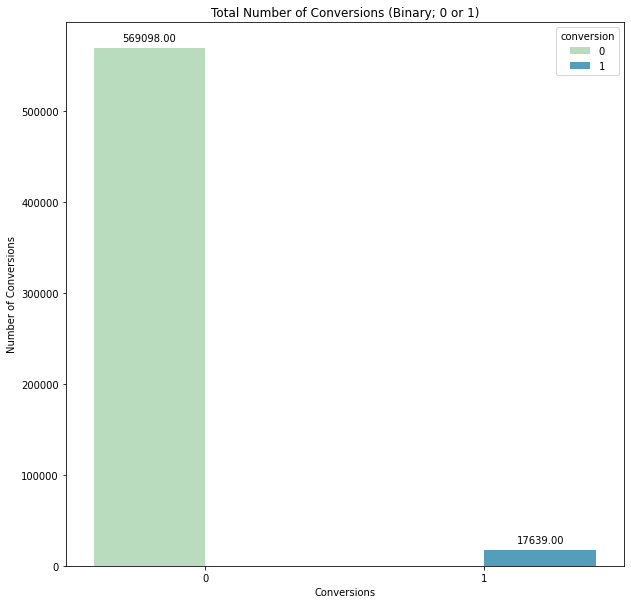

In [19]:
plt.figure(figsize = (10,10))
ax = sns.countplot(data = df, x = "conversion", hue = "conversion", palette = "GnBu")
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0,10), textcoords = 'offset points') # Adding in data labels
ax.set(xlabel = 'Conversions', ylabel = 'Number of Conversions', title = "Total Number of Conversions (Binary; 0 or 1)")
plt.show()

In [20]:
conversion_1 = df[df.conversion == 1]
print("Number of successful conversions (== 1): ", len(conversion_1))
conversion_0 = df[df.conversion == 0]
print("Number of non-successful conversions (== 0): ", len(conversion_0))

Number of successful conversions (== 1):  17639
Number of non-successful conversions (== 0):  569098


#### 2.1.2 Number of Conversions per Channel

The following plot indicates which channel had the highest number of conversions in the dataset. In this case, customers mainly viewed the 'su' scene in a virtual tour.

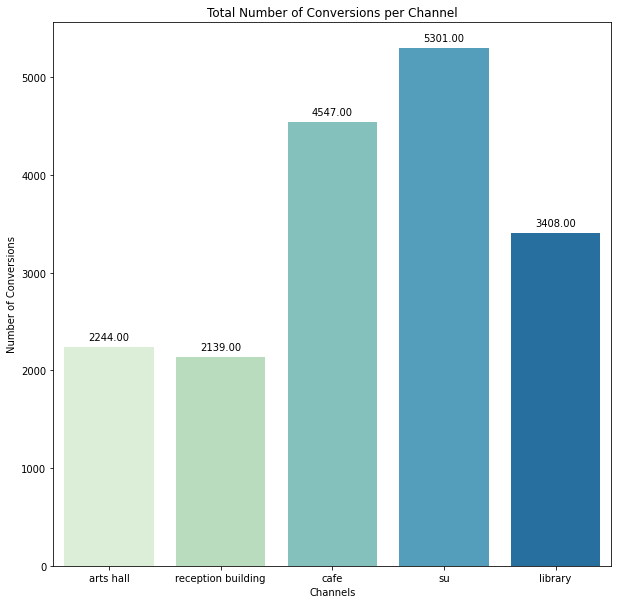

In [21]:
plt.figure(figsize = (10,10))
ax = sns.barplot(data = df, x = "channel", y = "conversion", palette = "GnBu", ci = None, estimator = sum)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0,10), textcoords = 'offset points') # Adding in data labels
ax.set(xlabel = 'Channels', ylabel = 'Number of Conversions', title = "Total Number of Conversions per Channel")
plt.show()

### 2.2 Data Preprocessing

The dataset being used requires some preprocessing steps so it is in the correct format to apply the Markov Chain algorithm. In this case, we are only interested in the following columns:
- 'cookie' - to be used as an ID
- 'conversion' - the conversion number; whether a conversion occurred or not (binary: 0 or 1)
- 'channel' - the channels that resulted in the customer investigating the client's company further

The final dataframe produced contains only the 'cookie' and an improved 'channel' column; renamed 'cookieID' and 'UserJourney'. The 'conversion' column was used to determine the strings to put either side of the channels for that specific 'cookie' - i.e. if conversion = 0, the string was 'Null' and if 1 the string is set to 'Conversion'. This column now looks similar to a user journey with a 'Start', channel name(s) and 'Null'/'Conversion'.


In [22]:
def dataframe_preprocessing(df):
    df = df.sort_values(['cookie', 'time'], ascending = [False, True])

    df_paths = df.groupby('cookie')['channel'].aggregate(lambda x: x.unique().tolist()).reset_index()
    df_last_interaction = df.drop_duplicates('cookie', keep = 'last')[['cookie', 'conversion']]
    df_paths = pd.merge(df_paths, df_last_interaction, how = 'left', on = 'cookie') # Merge two dataframes together

    # If 'conversion' == 0, add 'Null' to the user journey. Otherwise, add 'Conversion'
    df_paths['path'] = np.where(df_paths['conversion'] == 0, 
                                ['Start,'] + df_paths['channel'].apply(','.join) + [',Null'],
                                ['Start,'] + df_paths['channel'].apply(','.join) + [',Conversion'])
    df_paths['path'] = df_paths['path'].str.split(',')

    df_paths = df_paths[['cookie', 'path']] # Remove unwanted columns
    df_paths.columns = ['CookieID', 'UserJourney'] # Rename columns

    return df_paths

df_paths = dataframe_preprocessing(df)
display(df_paths.head())

,CookieID,UserJourney
0,00000FkCnDfDDf0iC97iC703B,"[Start, arts hall, reception building, Null]"
1,0000nACkD9nFkBBDECD3ki00E,"[Start, cafe, Null]"
2,0003EfE37E93D0BC03iBhBBhF,"[Start, cafe, Null]"
3,00073CFE3FoFCn70fBhB3kfon,"[Start, arts hall, Null]"
4,00079hhBkDF3k3kDkiFi9EFAD,"[Start, cafe, Null]"


## 3. Markov Chains

There are several steps to conducting the Markov Chain model. The following cells contain calculations with the aid of helper functions.

### 3.1 Conversion Rate

The cell below indicates the conversion rate within the dataset - i.e. the proportion of user journeys that resulted in a conversion.

In [23]:
list_of_user_journeys = df_paths['UserJourney'] # List of all user journeys

total_conversions = sum(UserJourney.count('Conversion') for UserJourney in df_paths['UserJourney'].tolist()) # Sum the number of conversions (i.e. conversion == 1)
print("Total Conversions: ", total_conversions)
base_conversion_rate = total_conversions / len(list_of_user_journeys) # Divide the number of conversions with the total number of conversions (both 0 and 1)    
print("Conversion Rate: ", base_conversion_rate)

Total Conversions:  17639
Conversion Rate:  0.07346277508454528


### 3.2 Helper Functions

The following five cells contain helper functions to:
- Identify all potential state transitions
- Calculate transition probabilities
- Identify removal effects for each channel
- Identify the impact removal of channels has

With thanks to [Morten Hegewald](https://towardsdatascience.com/marketing-channel-attribution-with-markov-chains-in-python-part-2-the-complete-walkthrough-733c65b23323).

#### 3.2.1 State Transitions

In [24]:
def transition_states(list_of_user_journeys):
    """
    identifies all potential state transitions and outputs a dictionary containing these
    """
    list_of_unique_channels = set(x for element in list_of_user_journeys for x in element) # Get list of unique channels
    print("Uniqe Virtual Tour Scenes: ", list_of_unique_channels, "\n")

    transition_states = {x + '>' + y: 0 for x in list_of_unique_channels for y in list_of_unique_channels} # Take each unique channel and pair with other unique channel and set value to 0

    for possible_state in list_of_unique_channels:
        if possible_state not in ['Conversion', 'Null']:
            for user_journey in list_of_user_journeys: # For every user path (i.e. row in df_paths['path])
                if possible_state in user_journey:
                    indices = [i for i, s in enumerate(user_journey) if possible_state in s]
                    for col in indices:
                        transition_states[user_journey[col] + '>' + user_journey[col + 1]] += 1
    return transition_states

trans_states = transition_states(list_of_user_journeys)
print("Transition States: \n", trans_states)

Uniqe Marketing Channels:  {'Start', 'Null', 'su', 'Conversion', 'reception building', 'arts hall', 'cafe', 'library'} 

Transition States: 
 {'Start>Start': 0, 'Start>Null': 0, 'Start>su': 66848, 'Start>Conversion': 0, 'Start>reception building': 34250, 'Start>arts hall': 28618, 'Start>cafe': 76210, 'Start>library': 34182, 'Null>Start': 0, 'Null>Null': 0, 'Null>su': 0, 'Null>Conversion': 0, 'Null>reception building': 0, 'Null>arts hall': 0, 'Null>cafe': 0, 'Null>library': 0, 'su>Start': 0, 'su>Null': 59319, 'su>su': 0, 'su>Conversion': 4690, 'su>reception building': 2146, 'su>arts hall': 15252, 'su>cafe': 4464, 'su>library': 2254, 'Conversion>Start': 0, 'Conversion>Null': 0, 'Conversion>su': 0, 'Conversion>Conversion': 0, 'Conversion>reception building': 0, 'Conversion>arts hall': 0, 'Conversion>cafe': 0, 'Conversion>library': 0, 'reception building>Start': 0, 'reception building>Null': 32236, 'reception building>su': 2300, 'reception building>Conversion': 2144, 'reception building>re

#### 3.2.2 Transition Probabilities

In [28]:
def transition_prob(trans_dict):
    """
    Calculate all transition probabilities
    """
    list_of_unique_channels = set(x for element in list_of_user_journeys for x in element)

    trans_prob = defaultdict(lambda: dict)
    
    for state in list_of_unique_channels:
        if state not in ['Conversion', 'Null']:
            counter = 0
            index = [i for i, s in enumerate(trans_dict) if state + '>' in s]

            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    counter += trans_dict[list(trans_dict)[col]]
            for col in index:
                if trans_dict[list(trans_dict)[col]] >0:
                    state_prob = float((trans_dict[list(trans_dict)[col]])) / float(counter)
                    trans_prob[list(trans_dict)[col]] = state_prob        

    return trans_prob

trans_prob = transition_prob(trans_states)
print("Transition Probabilities: \n", trans_prob)

Transition Probabilities: 
 defaultdict(<function transition_prob.<locals>.<lambda> at 0x00000187A213DDC8>, {'Start>su': 0.2784080497109634, 'Start>reception building': 0.14264414346877238, 'Start>arts hall': 0.11918803205224315, 'Start>cafe': 0.31739883718993117, 'Start>library': 0.14236093757808985, 'su>Null': 0.6731234042553191, 'su>Conversion': 0.053219858156028366, 'su>reception building': 0.02435177304964539, 'su>arts hall': 0.1730723404255319, 'su>cafe': 0.05065531914893617, 'su>library': 0.025577304964539006, 'reception building>Null': 0.7566425687728852, 'reception building>su': 0.053985541263731104, 'reception building>Conversion': 0.05032391324758239, 'reception building>arts hall': 0.02936344005257722, 'reception building>cafe': 0.09238569148436766, 'reception building>library': 0.017298845178856444, 'arts hall>Null': 0.6297861157158452, 'arts hall>su': 0.2187765333764606, 'arts hall>Conversion': 0.057979218048760765, 'arts hall>reception building': 0.023531314438199977, 'a

#### 3.2.3 Transition Matrix

In [29]:
def transition_matrix(list_of_user_journeys, transition_probabilities):
    """
    Identify removal effects for each of our virtual tour scenes
    """
    trans_matrix = pd.DataFrame()
    list_of_unique_channels = set(x for element in list_of_user_journeys for x in element)

    for channel in list_of_unique_channels:
        trans_matrix[channel] = 0.00
        trans_matrix.loc[channel] = 0.00
        trans_matrix.loc[channel][channel] = 1.0 if channel in ['Conversion', 'Null'] else 0.0

    for key, value in transition_probabilities.items():
        origin, destination = key.split('>')
        trans_matrix.at[origin, destination] = value

    return trans_matrix


trans_matrix = transition_matrix(list_of_user_journeys, trans_prob)

**Transition Probabilities Visualisation**  

The following cell produces a heatmap of the transition matrix results (i.e. transition probabilities). This clearly shows that the probability of transitioning from 'cafe' or 'library' to a 'Null' conversion is high.

As discovered early on in this notebook, there was a higher non-successful conversion rate in this example dataset. Therefore, the higher transition probabilities being in the 'Null' column in this heatmap is expected.

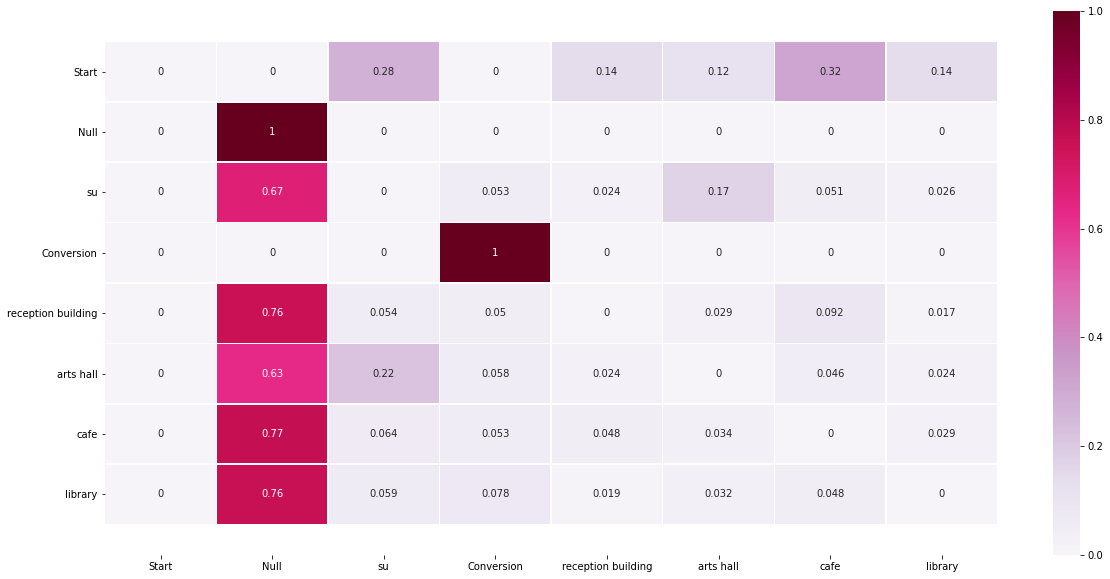

In [31]:
plt.figure(figsize = (20,10))
ax = sns.heatmap(trans_matrix, annot = True, cmap = "PuRd", linewidths = .5)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()
figure = ax.get_figure()
# figure.savefig("heatmap.png")

#### 3.2.4 Removal Effects

The cell below contains the function to calculate removal effect. Removal effect is a percentage that indicates what effect the removal of a virtual tour scene would have on the number of conversions.

In [34]:
def removal_effects(df, conversion_rate):
    """
    Iteratively go through each of our channels and assess the impact it would have on overall conversion if we were to remove a channel from the state-space
    """
    removal_effects_dict = {}
    channels = [channel for channel in df.columns if channel not in ['Start',
                                                                     'Null',
                                                                     'Conversion']]
    for channel in channels:
        removal_df = df.drop(channel, axis=1).drop(channel, axis=0)
        for column in removal_df.columns:
            row_sum = np.sum(list(removal_df.loc[column]))
            null_pct = float(1) - row_sum
            if null_pct != 0:
                removal_df.loc[column]['Null'] = null_pct
            removal_df.loc['Null']['Null'] = 1.0

        removal_to_conv = removal_df[
            ['Null', 'Conversion']].drop(['Null', 'Conversion'], axis=0)
        removal_to_non_conv = removal_df.drop(
            ['Null', 'Conversion'], axis=1).drop(['Null', 'Conversion'], axis=0)

        removal_inv_diff = np.linalg.inv(
            np.identity(
                len(removal_to_non_conv.columns)) - np.asarray(removal_to_non_conv))
        removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))
        removal_cvr = pd.DataFrame(removal_dot_prod,
                                   index=removal_to_conv.index)[[1]].loc['Start'].values[0]
        removal_effect = 1 - removal_cvr / conversion_rate
        removal_effects_dict[channel] = removal_effect

    return removal_effects_dict


removal_effects_dict = removal_effects(trans_matrix, base_conversion_rate)
print("Removal effects for each virtual tour scene: ", removal_effects_dict)

Removal effects for each virtual tour scene:  {'su': 0.3547597674182721, 'reception building': 0.15435482356041275, 'arts hall': 0.21731366149038445, 'cafe': 0.3311037560086154, 'library': 0.20691411655642178}


**Removal Effect Visualisation**  
As the bar plot below shows, the 'su' scene has the highest removal effect (0.35). Theoretically, if the 'su' scene wasn't included in the virtual tour, around 35% of all conversions could be lost.

,Channels,RemovalEffects
0,su,0.35
1,reception building,0.15
2,arts hall,0.22
3,cafe,0.33
4,library,0.21


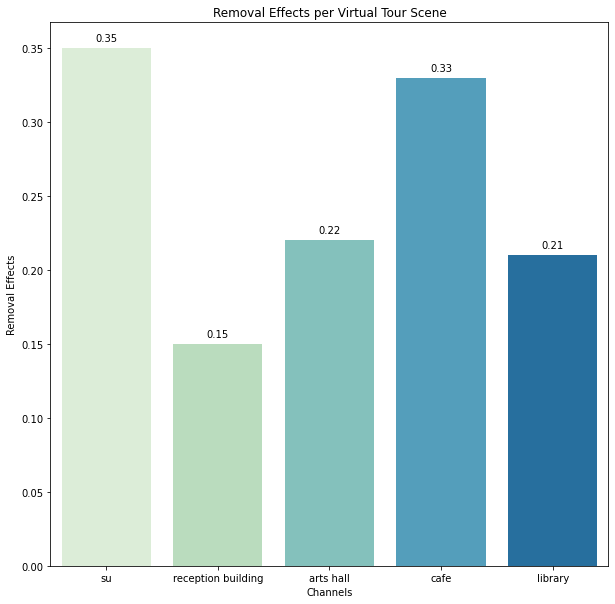

In [35]:
removal_effects_df = pd.DataFrame(list(removal_effects_dict.items())) # Convert dictionary results into Pandas Dataframe
removal_effects_df.columns = ['Channels', 'RemovalEffects'] # Rename columns
decimals = 2
removal_effects_df['RemovalEffects'] = removal_effects_df['RemovalEffects'].apply(lambda x: round(x, decimals)) # round removal effect to 2 decimal places
display(removal_effects_df)

# Bar Plot
plt.figure(figsize = (10,10))
ax = sns.barplot(data = removal_effects_df, x = "Channels", y = "RemovalEffects", palette = "GnBu", ci = None, estimator = sum)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0,10), textcoords = 'offset points') # Adding in data labels
ax.set(xlabel = 'Channels', ylabel = 'Removal Effects', title = "Removal Effects per Virtual Tour Scene")
plt.show()

#### 3.2.5 Markov Chain Attributions

This final calculation, shown in the cell below, indicates the total number of conversion attributed to each virtual tour scene (i.e. channel) by the Markov Chain algorithm.

In [36]:
def markov_chain_allocations(removal_effects, total_conversions):
    """
    Calculate the Markov Chain attributions for each of the marketing channels
    """
    re_sum = np.sum(list(removal_effects.values()))

    return {k: (v / re_sum) * total_conversions for k, v in removal_effects.items()}


attributions = markov_chain_allocations(removal_effects_dict, total_conversions)
attributions = {k: v for k, v in sorted(attributions.items(), key = lambda item: item[1])} # Sort dictionary values
print(attributions)

{'reception building': 2153.2469267590823, 'library': 2886.4480895461456, 'arts hall': 3031.5215485558915, 'cafe': 4618.891257291356, 'su': 4948.892177847523}


### 3.2 Analysis of Markov Chain Results

The following cell displays a bar chart containing the results of the Markov Chain algorithm (calculated in the cell above). It is clear that the 'su' virtual tour scene has the highest number of conversions where 'reception building' has the lowest.

,Channels,NumberofConversions
0,reception building,2153.0
1,library,2886.0
2,arts hall,3032.0
3,cafe,4619.0
4,su,4949.0


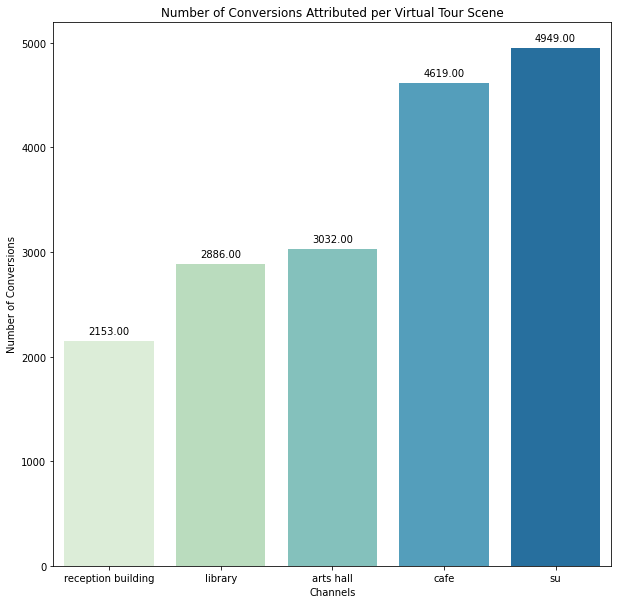

In [37]:
markov_chain_df = pd.DataFrame(list(attributions.items())) # Convert dictionary results into Pandas Dataframe
markov_chain_df.columns = ['Channels', 'NumberofConversions'] # Rename columns
decimals = 0
markov_chain_df['NumberofConversions'] = markov_chain_df['NumberofConversions'].apply(lambda x: round(x, decimals)) # round the number of conversions to 0 decimal places
display(markov_chain_df)

plt.figure(figsize = (10,10))
ax = sns.barplot(data = markov_chain_df, x = "Channels", y = "NumberofConversions", palette = "GnBu", ci = None, estimator = sum)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0,10), textcoords = 'offset points') # Adding in data labels
ax.set(xlabel = 'Channels', ylabel = 'Number of Conversions', title = "Number of Conversions Attributed per Virtual Tour Scene")
plt.show()